Divide data into 5 folds, and choose $K = \frac{\text{# of channels}}{2}$ for each fold.

When lots of data available, use prediction from thresholding to encode MoG.

When little data available (regional), use prediction from decoder to encode MoG.

In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from clusterless import preprocess

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [163]:
SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### prepare data

In [4]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/'

In [301]:
rois = [roi.lower() for roi in ['PO', 'LP', 'DG', 'CA1', 'VIS']]
roi = rois[4]
print(roi)

vis


In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    # roi=roi,
    roi='all',
    kilosort=False,
    triage=False
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [6]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, train_ids, test_ids):
        
        self.train_ids = self.rand_trial_ids[train_ids]
        self.test_ids = self.rand_trial_ids[test_ids]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids == idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids == idx for idx in self.test_ids], axis=0).astype(bool)
        train_trial_ids, test_trial_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_trial_ids, train_t_ids, \
               test_trials, test_trial_ids, test_t_ids
    
    
    def compute_lambda(self, gmm):
        C = len(gmm.means_)
        lambdas = []
        for k in self.train_ids:
            lam_lst = []
            for t in range(self.n_t_bins):
                lam = np.zeros((C, 2))
                t_bin = self.trials[k][t]
                if len(t_bin) > 0:
                    cluster_ids = gmm.predict(t_bin)
                    for j in range(C):
                        if self.y[k] == 0:
                            lam[j, 0] = np.sum(cluster_ids == j)
                        else:
                            lam[j, 1] = np.sum(cluster_ids == j)
                lam_lst.append(lam)
            lambdas.append(lam_lst)
        n_left, n_right = np.sum(self.y_train == 0), np.sum(self.y_train == 1)
        p = n_right / (n_right + n_left)
        lambdas = ( np.array(lambdas).sum(0) / np.array([n_left, n_right]) ).transpose(1,0,2)
        return lambdas, p 

In [7]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,2,3,4]], 
                         y = choices.argmax(1), 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=10)

In [8]:
# kf = KFold(n_splits=5, shuffle=True, random_state=seed)
kf = KFold(n_splits=5, shuffle=False)
kf_train_ids = []; kf_test_ids = []
for i, (train_ids, test_ids) in enumerate(kf.split(data_loader.y)):
    kf_train_ids.append(train_ids)
    kf_test_ids.append(test_ids)

In [111]:
i = 4
train_trials, train_trial_ids, train_t_ids, \
test_trials, test_trial_ids, test_t_ids = data_loader.split_train_test(
    train_ids = kf_train_ids[i], test_ids = kf_test_ids[i]
)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [112]:
C = 150
gmm = GaussianMixture(n_components = C, 
                      covariance_type = 'full', 
                      # covariance_type = 'spherical', 
                      init_params = 'kmeans',
                      verbose=1)
gmm.fit(train_trials)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


GaussianMixture(n_components=150, verbose=1)

In [113]:
lambdas, p = data_loader.compute_lambda(gmm)

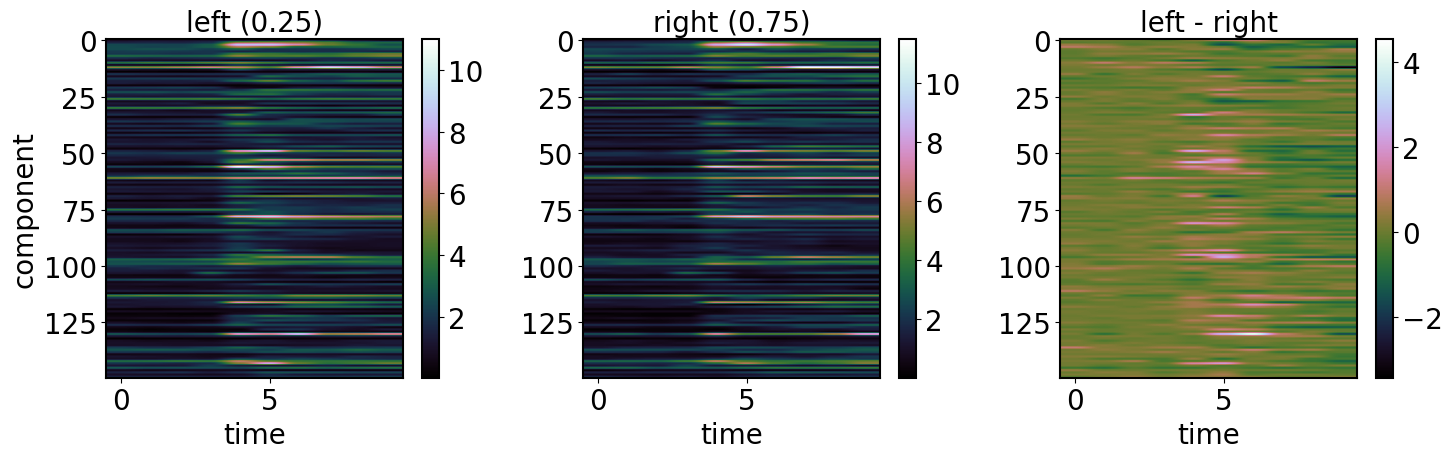

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

f1 = ax1.imshow(lambdas[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title(f'left ({p:.2f})')
ax1.set_xlabel('time')
ax1.set_ylabel('component')
fig.colorbar(f1, ax = ax1)

f2 = ax2.imshow(lambdas[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title(f'right ({1-p:.2f})')
ax2.set_xlabel('time')
fig.colorbar(f2, ax = ax2)

f3 = ax3.imshow(lambdas[:,:,0] - lambdas[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('left - right')
ax3.set_xlabel('time')
fig.colorbar(f3, ax = ax3)

plt.tight_layout()

#### CAVI

In [115]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

def safe_divide(x, y):
    return torch.clip(x / y, min = 0, max = 1)

In [116]:
class CAVI():
    def __init__(self, init_mu, init_cov, init_lam, 
                 train_k_ids, train_t_ids, test_k_ids, test_t_ids):
        
        self.train_K = len(train_k_ids)
        self.test_K = len(test_k_ids)
        self.T = len(train_t_ids)
        self.C = init_mu.shape[0]
        self.D = init_mu.shape[1]
        self.init_mu = init_mu
        self.init_cov = init_cov
        self.init_lam = init_lam
        self.train_k_ids = train_k_ids
        self.train_t_ids = train_t_ids
        self.test_k_ids = test_k_ids
        self.test_t_ids = test_t_ids
        
    
    def _compute_normal_log_dens(self, s, mu, cov, safe_cov=None):
        
        log_dens = []
        for j in range(self.C):
            try:
                log_dens.append(
                    torch.tensor(
                        multivariate_normal.logpdf(s, mu[j], cov[j])
                    )
                )
            except np.linalg.LinAlgError:
                # error occurs when cov is not PSD
                # use initial cov as a replacement to ensure numerical stability
                # need a better solution 
                log_dens.append(
                    torch.tensor(
                        multivariate_normal.logpdf(s, mu[j], safe_cov[j])
                    )
                )
                print(f'cov {j} is not PSD.')
        return torch.vstack(log_dens).T # (*, C)
    
    
    def _compute_enc_elbo(self, r, y, log_dens, norm_lam):
        
        elbo_1 = torch.sum(torch.tensor(
            [torch.einsum('i,i->', r[:,j], log_dens[:,j]) for j in range(self.C)]
        ))

        elbo_2 = torch.tensor(
            [ torch.einsum('ij,il,j->', r[self.train_t_ids[t]], 
                           y[self.train_t_ids[t]], norm_lam[:,t,1]) +
              torch.einsum('ij,il,j->', r[self.train_t_ids[t]], 
                           1-y[self.train_t_ids[t]], norm_lam[:,t,0]) for t in range(self.T) ]
            ).sum()

        elbo_3 = - torch.einsum('ij,ij->', safe_log(r), r)

        elbo = elbo_1 + elbo_2 + elbo_3 

        return elbo
    
    
    def _compute_dec_elbo(self, r, log_dens, norm_lam, nu, nu_k, p):
        
        elbo_1 = torch.sum(torch.tensor(
            [torch.einsum('i,i->', r[:,j], log_dens[:,j]) for j in range(self.C)]
        ))

        elbo_2 = torch.tensor(
            [ torch.einsum('ij,il,j->', r[self.test_t_ids[t]], 
                           nu[self.test_t_ids[t]], norm_lam[:,t,1]) +
              torch.einsum('ij,il,j->', r[self.test_t_ids[t]], 
                           1-nu[self.test_t_ids[t]], norm_lam[:,t,0]) for t in range(self.T) ]
            ).sum()

        elbo_3 = torch.sum(nu_k * safe_log(p) + (1-nu_k) * safe_log(1-p))

        elbo_4 = - torch.einsum('ij,ij->', safe_log(r), r)

        elbo_5 = - torch.sum(safe_log(nu_k) * nu_k)

        elbo = elbo_1 + elbo_2 + elbo_3 + elbo_4 + elbo_5

        return elbo
    
    
    def _encode_e_step(self, r, y, log_dens, norm_lam):
        
        for t in range(self.T):
            r[self.train_t_ids[t]] = torch.exp( log_dens[self.train_t_ids[t]] + \
                      torch.einsum('il,j->ij', y[self.train_t_ids[t]], norm_lam[:,t,1]) + \
                      torch.einsum('il,j->ij', 1-y[self.train_t_ids[t]], norm_lam[:,t,0])
            )
            r[self.train_t_ids[t]] = torch.einsum('ij,i->ij', r[self.train_t_ids[t]], 1/r[self.train_t_ids[t]].sum(1))
        return r
        
    
    def _encode_m_step(self, s, r, y, mu, lam):
        
        for j in range(self.C):
            no_j_idx = torch.cat([torch.arange(j), torch.arange(j+1, self.C)])
            lam_sum_no_j = lam[no_j_idx,:,:].sum(0)
            for t in range(self.T):
                num1 = torch.einsum('i,il,->', r[self.train_t_ids[t],j], y[self.train_t_ids[t]], lam_sum_no_j[t,1])
                denom1 = np.einsum('ij,il->', r[self.train_t_ids[t]][:,no_j_idx], y[self.train_t_ids[t]])
                num0 = torch.einsum('i,il,->', r[self.train_t_ids[t],j], 1-y[self.train_t_ids[t]], lam_sum_no_j[t,0])
                denom0 = np.einsum('ij,il->', r[self.train_t_ids[t]][:,no_j_idx], 1-y[self.train_t_ids[t]])
                lam[j,t,1], lam[j,t,0] = num1 / denom1, num0 / denom0
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))

        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j] ) for j in range(self.C)]
        
        return mu, cov, lam, norm_lam
    
    
    def _decode_e_step(self, r, log_dens, norm_lam, nu, nu_k, p):
        
        for t in range(self.T):
            r[self.test_t_ids[t]] = torch.exp( log_dens[self.test_t_ids[t]] + \
                      torch.einsum('il,j->ij', nu[self.test_t_ids[t]], norm_lam[:,t,1]) + \
                      torch.einsum('il,j->ij', 1-nu[self.test_t_ids[t]], norm_lam[:,t,0])
            )
            r[self.test_t_ids[t]] = torch.einsum('ij,i->ij', r[self.test_t_ids[t]], 1/r[self.test_t_ids[t]].sum(1))
        
        for k in range(self.test_K):
            y_tilde0, y_tilde1 = safe_log(1-p), safe_log(p)
            for t in range(self.T):
                k_t_ids = np.intersect1d(self.test_k_ids[k], self.test_t_ids[t])
                y_tilde0 += torch.einsum('ij,j->', r[k_t_ids], norm_lam[:,t,0])
                y_tilde1 += torch.einsum('ij,j->', r[k_t_ids], norm_lam[:,t,1])
            # y_tilde explode to 0 after exp(); need offset to ensure y_tilde stay in range
            # offset = 1. / (torch.min(torch.tensor([y_tilde0, y_tilde1])) / -745.) 
            offset = 1. / (torch.min(torch.tensor([y_tilde0, y_tilde1])) / -250.)
            y_tilde0, y_tilde1 = torch.exp(y_tilde0 * offset), torch.exp(y_tilde1 * offset)
            nu_k[k] = safe_divide(y_tilde1, y_tilde0 + y_tilde1)
            nu[self.test_k_ids[k]] = nu_k[k]
            
        return r, nu, nu_k
    
    
    def _decode_m_step(self, s, r, nu_k, mu):
        
        p = nu_k.sum() / self.test_K
    
        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j]) for j in range(self.C)]
        
        return p, mu, cov
    
    
    def encode(self, s, y, max_iter=20, eps=1e-6):
        # initialize
        r = torch.ones((s.shape[0], self.C)) / self.C
        lam = self.init_lam.clone()
        mu, cov = self.init_mu.clone(), self.init_cov.clone()
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))
        
        # compute initial elbo
        log_dens = self._compute_normal_log_dens(s, mu, cov, safe_cov=self.init_cov)
        elbo = self._compute_enc_elbo(r, y, log_dens, norm_lam)
        convergence = 1.
        elbos = [elbo]
        print(f'initial elbo: {elbos[-1]:.2f}')
        
        it = 1
        while convergence > eps or convergence < 0: 
            # E step
            r = self._encode_e_step(r, y, log_dens, norm_lam)
            
            # M step
            mu, cov, lam, norm_lam = self._encode_m_step(s, r, y, mu, lam)
            
            # compute new elbo
            log_dens = self._compute_normal_log_dens(s, mu, cov, safe_cov=self.init_cov)
            elbo = self._compute_enc_elbo(r, y, log_dens, norm_lam)
            elbos.append(elbo)
            convergence = elbos[-1] - elbos[-2]

            print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
            it +=1 
            if it > max_iter: 
                print('reached max iter allowed.')
                break

        if abs(convergence) <= eps:
            print('converged.')
            
        return r, lam, mu, torch.stack(cov), elbos
    
    
    def decode(self, s, init_p, init_mu, init_cov, init_lam, 
                test_k_ids, test_ids, max_iter=20, eps=1e-6):
        # initialize
        p = init_p.clone()
        r = torch.ones((s.shape[0], self.C)) / self.C
        mu, cov = init_mu.clone(), init_cov.clone()
        lam = init_lam.clone()
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))
        nu_k = torch.rand(self.test_K)
        nu = torch.zeros(s.shape[0])
        for k in range(self.test_K):
            nu[test_k_ids == test_ids[k]] = nu_k[k]
        nu = nu.reshape(-1,1)
        
        # compute initial elbo
        log_dens = self._compute_normal_log_dens(s, mu, cov, safe_cov=init_cov)
        elbo = self._compute_dec_elbo(r, log_dens, norm_lam, nu, nu_k, p)
        convergence = 1.
        elbos = [elbo]
        print(f'initial elbo: {elbos[-1]:.2f}')
        
        it = 1
        while convergence > eps or convergence < 0:
            # E step
            r, nu, nu_k = self._decode_e_step(r, log_dens, norm_lam, nu, nu_k, p)
            
            # M step
            p, mu, cov = self._decode_m_step(s, r, nu_k, mu)
            
            # compute new elbo
            log_dens = self._compute_normal_log_dens(s, mu, cov, safe_cov=init_cov)
            elbo = self._compute_dec_elbo(r, log_dens, norm_lam, nu, nu_k, p)
            elbos.append(elbo)
            convergence = elbos[-1] - elbos[-2]

            print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
            it +=1 
            if it > max_iter: 
                print('reached max iter allowed.')
                break

        if abs(convergence) <= eps:
            print('converged.')
    
        return r, nu_k, mu, torch.stack(cov), p, elbos
    
    
    def eval_performance(self, nu_k, y_test):
        acc = accuracy_score(y_test, 1. * ( nu_k > .5 ))
        auc = roc_auc_score(y_test, nu_k)
        print(f'decoding accuracy is {acc:.2f}')
        print(f'decoding auc is {auc:.2f}')
        return acc, auc

#### Run

In [117]:
C = len(gmm.means_)
T = lambdas.shape[1]

y_train = torch.zeros(train_trials.shape[0])
for k_idx, k in enumerate(data_loader.train_ids):
    y_train[train_trial_ids == k] = data_loader.y_train[k_idx]
y_train = y_train.reshape(-1,1)

In [118]:
cavi = CAVI(
    init_mu = torch.tensor(gmm.means_), 
    init_cov = torch.tensor(gmm.covariances_), 
    init_lam = torch.tensor(lambdas), 
    train_k_ids = [torch.argwhere(torch.tensor(train_trial_ids) == k).reshape(-1) for k in data_loader.train_ids], 
    train_t_ids = [torch.argwhere(torch.tensor(train_t_ids) == t).reshape(-1) for t in range(T)],
    test_k_ids = [torch.argwhere(torch.tensor(test_trial_ids) == k).reshape(-1) for k in data_loader.test_ids],
    test_t_ids = [torch.argwhere(torch.tensor(test_t_ids) == t).reshape(-1) for t in range(T)]
)

In [119]:
%%time
enc_r, enc_lam, enc_mu, enc_cov, enc_elbo = cavi.encode(
    s = torch.tensor(train_trials),
    y = y_train, max_iter=30)

initial elbo: -23620841040.43
iter: 1 elbo: -7935066.90.
iter: 2 elbo: -7934075.60.
iter: 3 elbo: -7933470.67.
iter: 4 elbo: -7932961.61.
iter: 5 elbo: -7932508.49.
iter: 6 elbo: -7932096.28.
iter: 7 elbo: -7931711.79.
iter: 8 elbo: -7931346.70.
iter: 9 elbo: -7930991.22.
iter: 10 elbo: -7930631.91.
iter: 11 elbo: -7930212.54.
iter: 12 elbo: -7929325.46.
iter: 13 elbo: -7928592.13.
iter: 14 elbo: -7927869.70.
iter: 15 elbo: -7927149.07.
iter: 16 elbo: -7926555.20.
iter: 17 elbo: -7925925.41.
iter: 18 elbo: -7925361.30.
iter: 19 elbo: -7925020.68.
iter: 20 elbo: -7924711.45.
iter: 21 elbo: -7924413.17.
iter: 22 elbo: -7924126.02.
iter: 23 elbo: -7923844.31.
iter: 24 elbo: -7923562.54.
iter: 25 elbo: -7923275.22.
iter: 26 elbo: -7922934.24.
iter: 27 elbo: -7922313.06.
iter: 28 elbo: -7921217.29.
iter: 29 elbo: -7920700.64.
iter: 30 elbo: -7920408.69.
reached max iter allowed.
CPU times: user 3h 47min 43s, sys: 26min 28s, total: 4h 14min 12s
Wall time: 31min 48s


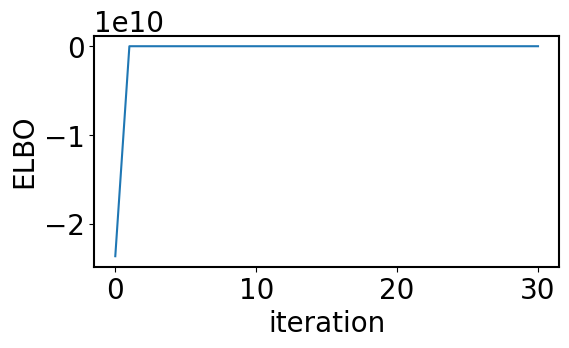

In [120]:
plt.figure(figsize=(6,3))
plt.plot(enc_elbo)
plt.xlabel('iteration')
plt.ylabel('ELBO')
pass

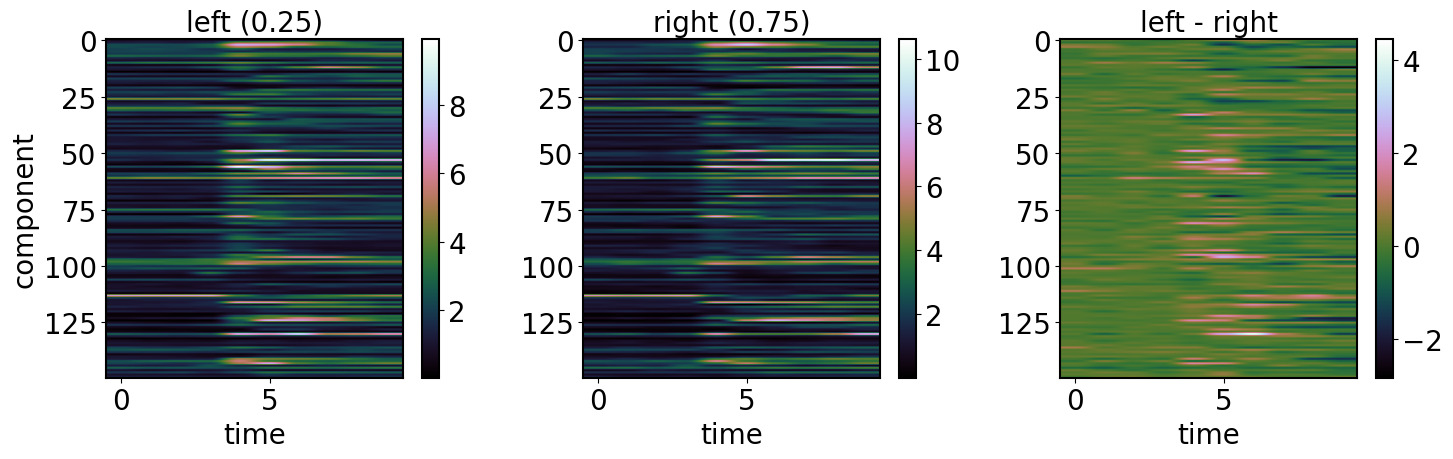

In [121]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

f1 = ax1.imshow(enc_lam[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title(f'left ({p:.2f})')
ax1.set_xlabel('time')
ax1.set_ylabel('component')
fig.colorbar(f1, ax = ax1)

f2 = ax2.imshow(enc_lam[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title(f'right ({1-p:.2f})')
ax2.set_xlabel('time')
fig.colorbar(f2, ax = ax2)

f3 = ax3.imshow(enc_lam[:,:,0] - enc_lam[:,:,1], aspect='auto', cmap='cubehelix')
ax3.set_title('left - right')
ax3.set_xlabel('time')
fig.colorbar(f3, ax = ax3)

plt.tight_layout()

In [122]:
dec_r, dec_nu, dec_mu, dec_cov, dec_p, dec_elbos = cavi.decode(
    s = torch.tensor(test_trials),
    init_p = torch.tensor([p]), 
    init_mu = enc_mu, 
    init_cov = enc_cov, 
    init_lam = enc_lam, 
    test_k_ids = test_trial_ids, 
    test_ids = data_loader.test_ids, 
    max_iter=10
)

initial elbo: -6551068738.56
iter: 1 elbo: -1961605.91.
iter: 2 elbo: -1953470.41.
iter: 3 elbo: -1951097.85.
iter: 4 elbo: -1949847.31.
iter: 5 elbo: -1949071.10.
iter: 6 elbo: -1948486.08.
iter: 7 elbo: -1947974.84.
iter: 8 elbo: -1947489.95.
iter: 9 elbo: -1947039.11.
iter: 10 elbo: -1946727.27.
reached max iter allowed.


In [123]:
# plt.figure(figsize=(6,3))
# plt.plot(dec_elbos)
# plt.xlabel('iteration')
# plt.ylabel('ELBO')
# pass

#### eval

In [124]:
cavi.eval_performance(dec_nu, data_loader.y_test)

decoding accuracy is 0.91
decoding auc is 0.99


(0.9056603773584906, 0.9942307692307693)

In [134]:
cavi_xval_all_accs = [0.81, 0.87, 0.91, 0.96, 0.91] 
cavi_xval_all_aucs = [0.88, 0.94, 0.95, 0.99, 0.99]
cavi_xval_po_accs = [0.83, 0.74, 0.75, 0.85, 0.87]
cavi_xval_po_aucs = [0.84, 0.79, 0.87, 0.98, 0.93]
cavi_xval_lp_accs = [0.79, 0.83, 0.85, 0.92, 0.89]
cavi_xval_lp_aucs = [0.81, 0.97, 0.91, 0.99, 0.91]
cavi_xval_dg_accs = [0.77, 0.87, 0.66, 0.70, 0.75]
cavi_xval_dg_aucs = [0.79, 0.90, 0.76, 0.72, 0.75]
cavi_xval_ca1_accs = [0.72, 0.75, 0.72, 0.74, 0.74]
cavi_xval_ca1_aucs = [0.72, 0.59, 0.75, 0.75, 0.80]
cavi_xval_vis_accs = [0.72, 0.77, 0.70, 0.83, 0.75]
cavi_xval_vis_aucs = [0.62, 0.78, 0.78, 0.87, 0.73]

In [135]:
print(f'all acc: {np.mean(cavi_xval_all_accs):.2f} auc: {np.mean(cavi_xval_all_aucs):.2f}')
print(f'po acc: {np.mean(cavi_xval_po_accs):.2f} auc: {np.mean(cavi_xval_po_aucs):.2f}')
print(f'lp acc: {np.mean(cavi_xval_lp_accs):.2f} auc: {np.mean(cavi_xval_lp_aucs):.2f}')
print(f'dg acc: {np.mean(cavi_xval_dg_accs):.2f} auc: {np.mean(cavi_xval_dg_aucs):.2f}')
print(f'ca1 acc: {np.mean(cavi_xval_ca1_accs):.2f} auc: {np.mean(cavi_xval_ca1_aucs):.2f}')
print(f'vis acc: {np.mean(cavi_xval_vis_accs):.2f} auc: {np.mean(cavi_xval_vis_aucs):.2f}')

all acc: 0.89 auc: 0.95
po acc: 0.81 auc: 0.88
lp acc: 0.86 auc: 0.92
dg acc: 0.75 auc: 0.78
ca1 acc: 0.73 auc: 0.72
vis acc: 0.75 auc: 0.76


#### thresholded

In [125]:
n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=10,
    # regional=True
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (265, 380, 10)


In [126]:
x_train = thresholded_neural_data[data_loader.train_ids].reshape(-1, thresholded_neural_data.shape[1]*thresholded_neural_data.shape[-1])
x_test = thresholded_neural_data[data_loader.test_ids].reshape(-1, thresholded_neural_data.shape[1]*thresholded_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, solver='liblinear').fit(x_train, data_loader.y_train)
probs = decoder.predict_proba(x_test)
threshold_preds = probs.argmax(1)
acc = accuracy_score(data_loader.y_test, threshold_preds)
auc = roc_auc_score(choices[data_loader.test_ids], probs)
print(f'{acc:.2f}')
print(f'{auc:.2f}')

0.91
0.98


In [136]:
thresh_xval_all_accs = [0.85, 0.87, 0.85, 0.94, 0.91]
thresh_xval_all_aucs = [0.94, 0.97, 0.95, 0.99, 0.98]
thresh_xval_po_accs = [0.79, 0.87, 0.83, 0.81, 0.83]
thresh_xval_po_aucs = [0.80, 0.97, 0.91, 0.87, 0.89]
thresh_xval_lp_accs = [0.79, 0.81, 0.79, 0.89, 0.91]
thresh_xval_lp_aucs = [0.78, 0.94, 0.90, 0.95, 0.93]
thresh_xval_dg_accs = [0.77, 0.79, 0.64, 0.70, 0.81]
thresh_xval_dg_aucs = [0.83, 0.76, 0.57, 0.73, 0.76]
thresh_xval_ca1_accs = [0.70, 0.68, 0.66, 0.75, 0.60]
thresh_xval_ca1_aucs = [0.53, 0.61, 0.59, 0.69, 0.60]
thresh_xval_vis_accs = [0.60, 0.74, 0.58, 0.74, 0.72]
thresh_xval_vis_aucs = [0.54, 0.65, 0.56, 0.61, 0.53]

In [137]:
print(f'all acc: {np.mean(thresh_xval_all_accs):.2f} auc: {np.mean(thresh_xval_all_aucs):.2f}')
print(f'po acc: {np.mean(thresh_xval_po_accs):.2f} auc: {np.mean(thresh_xval_po_aucs):.2f}')
print(f'lp acc: {np.mean(thresh_xval_lp_accs):.2f} auc: {np.mean(thresh_xval_lp_aucs):.2f}')
print(f'dg acc: {np.mean(thresh_xval_dg_accs):.2f} auc: {np.mean(thresh_xval_dg_aucs):.2f}')
print(f'ca1 acc: {np.mean(thresh_xval_ca1_accs):.2f} auc: {np.mean(thresh_xval_ca1_aucs):.2f}')
print(f'vis acc: {np.mean(thresh_xval_vis_accs):.2f} auc: {np.mean(thresh_xval_vis_aucs):.2f}')

all acc: 0.88 auc: 0.97
po acc: 0.83 auc: 0.89
lp acc: 0.84 auc: 0.90
dg acc: 0.74 auc: 0.73
ca1 acc: 0.68 auc: 0.60
vis acc: 0.68 auc: 0.58


### encoded-MoG

In [127]:
enc_pi = enc_lam / enc_lam.sum(0) 
y_pred = 1 * (dec_nu > .5)
train_feat = [data_loader.trials[k] for k in data_loader.train_ids]
test_feat = [data_loader.trials[k] for k in data_loader.test_ids]

In [128]:
W_train = np.zeros((len(data_loader.train_ids), data_loader.n_t_bins, C))
for k in range(len(data_loader.train_ids)):
    for t in range(data_loader.n_t_bins):
        modulated_gmm =  GaussianMixture(n_components=C, covariance_type='full')
        modulated_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(dec_cov))
        modulated_gmm.weights_ = enc_pi[:, t, data_loader.y_train[k]].numpy()
        modulated_gmm.means_ = dec_mu.numpy()
        modulated_gmm.covariances_ = dec_cov.numpy()
        if len(train_feat[k][t]) > 0:
            W_train[k,t,:] = modulated_gmm.predict_proba(train_feat[k][t]).sum(0)

In [129]:
W_test = np.zeros((len(data_loader.test_ids), data_loader.n_t_bins, C))
for k in range(len(data_loader.test_ids)):
    for t in range(data_loader.n_t_bins):
        modulated_gmm =  GaussianMixture(n_components=C, covariance_type='full')
        modulated_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(dec_cov))
        modulated_gmm.weights_ = enc_pi[:, t, y_pred[k]].numpy()
        # modulated_gmm.weights_ = enc_pi[:, t, threshold_preds[k]].numpy()
        modulated_gmm.means_ = dec_mu.numpy()
        modulated_gmm.covariances_ = dec_cov.numpy()
        if len(test_feat[k][t]) > 0:
            W_test[k,t,:] = modulated_gmm.predict_proba(test_feat[k][t]).sum(0)

In [130]:
x_train = W_train.reshape(-1, W_train.shape[1]*W_train.shape[-1])
x_test = W_test.reshape(-1, W_test.shape[1]*W_test.shape[-1])
decoder = LogisticRegression(random_state=seed, solver='liblinear').fit(x_train, data_loader.y_train)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(data_loader.y_test, preds)
auc = roc_auc_score(choices[data_loader.test_ids], probs)
print(f'{acc:.2f}')
print(f'{auc:.2f}')

0.94
0.99


In [138]:
enc_mog_xval_all_accs = [0.87, 0.92, 0.92, 0.96, 0.94]
enc_mog_xval_all_aucs = [0.92, 0.98, 0.96, 1.00, 0.99]
enc_mog_xval_po_accs = [0.81, 0.89, 0.83, 0.89, 0.91]
enc_mog_xval_po_aucs = [0.87, 0.91, 0.91, 0.98, 0.96]
enc_mog_xval_lp_accs = [0.81, 0.89, 0.89, 0.92, 0.91]
enc_mog_xval_lp_aucs = [0.83, 0.99, 0.93, 0.98, 0.97]
enc_mog_xval_dg_accs = [0.77, 0.87, 0.66, 0.75, 0.79]
enc_mog_xval_dg_aucs = [0.79, 0.78, 0.70, 0.76, 0.74]
enc_mog_xval_ca1_accs = [0.72, 0.75, 0.72, 0.79, 0.81]
enc_mog_xval_ca1_aucs = [0.56, 0.66, 0.74, 0.80, 0.74]
enc_mog_xval_vis_accs = [0.72, 0.77, 0.74, 0.85, 0.74]
enc_mog_xval_vis_aucs = [0.70, 0.72, 0.77, 0.90, 0.59]

In [139]:
print(f'all acc: {np.mean(enc_mog_xval_all_accs):.2f} auc: {np.mean(enc_mog_xval_all_aucs):.2f}')
print(f'po acc: {np.mean(enc_mog_xval_po_accs):.2f} auc: {np.mean(enc_mog_xval_po_aucs):.2f}')
print(f'lp acc: {np.mean(enc_mog_xval_lp_accs):.2f} auc: {np.mean(enc_mog_xval_lp_aucs):.2f}')
print(f'dg acc: {np.mean(enc_mog_xval_dg_accs):.2f} auc: {np.mean(enc_mog_xval_dg_aucs):.2f}')
print(f'ca1 acc: {np.mean(enc_mog_xval_ca1_accs):.2f} auc: {np.mean(enc_mog_xval_ca1_aucs):.2f}')
print(f'vis acc: {np.mean(enc_mog_xval_vis_accs):.2f} auc: {np.mean(enc_mog_xval_vis_aucs):.2f}')

all acc: 0.92 auc: 0.97
po acc: 0.87 auc: 0.93
lp acc: 0.88 auc: 0.94
dg acc: 0.77 auc: 0.75
ca1 acc: 0.76 auc: 0.70
vis acc: 0.76 auc: 0.74


#### KS vs. IBL good units

In [131]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    # roi=roi,
    roi='all',
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)])
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]
spike_channels = unsorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=10,
    # regional=True
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=10,
    # regional=True
    regional=False
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
sorted neural data shape: (265, 514, 10)
good sorted neural data shape: (265, 83, 10)


In [132]:
x_train = sorted_neural_data[data_loader.train_ids].reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1])
x_test = sorted_neural_data[data_loader.test_ids].reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, solver='liblinear').fit(x_train, data_loader.y_train)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(data_loader.y_test, preds)
auc = roc_auc_score(choices[data_loader.test_ids], probs)
print(f'{acc:.2f}')
print(f'{auc:.2f}')

0.94
0.99


In [140]:
ks_xval_all_accs = [0.81, 0.98, 0.85, 0.96, 0.94]
ks_xval_all_aucs = [0.87, 1.00, 0.94, 0.99, 0.99]
ks_xval_po_accs = [0.74, 0.75, 0.81, 0.87, 0.91]
ks_xval_po_aucs = [0.79, 0.84, 0.89, 0.93, 0.93]
ks_xval_lp_accs = [0.79, 0.94, 0.83, 0.92, 0.89]
ks_xval_lp_aucs = [0.83, 0.99, 0.92, 0.96, 0.99]
ks_xval_dg_accs = [0.72, 0.74, 0.70, 0.70, 0.75]
ks_xval_dg_aucs = [0.67, 0.64, 0.62, 0.66, 0.74]
ks_xval_ca1_accs = [0.75, 0.68, 0.70, 0.75, 0.70]
ks_xval_ca1_aucs = [0.47, 0.63, 0.60, 0.66, 0.64]
ks_xval_vis_accs = [0.66, 0.72, 0.58, 0.72, 0.66]
ks_xval_vis_aucs = [0.64, 0.77, 0.56, 0.64, 0.60]

In [141]:
print(f'all acc: {np.mean(ks_xval_all_accs):.2f} auc: {np.mean(ks_xval_all_aucs):.2f}')
print(f'po acc: {np.mean(ks_xval_po_accs):.2f} auc: {np.mean(ks_xval_po_aucs):.2f}')
print(f'lp acc: {np.mean(ks_xval_lp_accs):.2f} auc: {np.mean(ks_xval_lp_aucs):.2f}')
print(f'dg acc: {np.mean(ks_xval_dg_accs):.2f} auc: {np.mean(ks_xval_dg_aucs):.2f}')
print(f'ca1 acc: {np.mean(ks_xval_ca1_accs):.2f} auc: {np.mean(ks_xval_ca1_aucs):.2f}')
print(f'vis acc: {np.mean(ks_xval_vis_accs):.2f} auc: {np.mean(ks_xval_vis_aucs):.2f}')

all acc: 0.91 auc: 0.96
po acc: 0.82 auc: 0.88
lp acc: 0.87 auc: 0.94
dg acc: 0.72 auc: 0.67
ca1 acc: 0.72 auc: 0.60
vis acc: 0.67 auc: 0.64


In [133]:
x_train = good_sorted_neural_data[data_loader.train_ids].reshape(-1, good_sorted_neural_data.shape[1]*good_sorted_neural_data.shape[-1])
x_test = good_sorted_neural_data[data_loader.test_ids].reshape(-1, good_sorted_neural_data.shape[1]*good_sorted_neural_data.shape[-1])
decoder = LogisticRegression(random_state=seed, solver='liblinear').fit(x_train, data_loader.y_train)
probs = decoder.predict_proba(x_test)
preds = probs.argmax(1)
acc = accuracy_score(data_loader.y_test, preds)
auc = roc_auc_score(choices[data_loader.test_ids], probs)
print(f'{acc:.2f}')
print(f'{auc:.2f}')

0.94
0.96


In [142]:
good_xval_all_accs = [0.85, 0.92, 0.83, 0.91, 0.94]
good_xval_all_aucs = [0.78, 0.97, 0.91, 0.98, 0.96]
good_xval_po_accs = [0.70, 0.72, 0.75, 0.81, 0.75]
good_xval_po_aucs = [0.52, 0.69, 0.79, 0.87, 0.72]
good_xval_lp_accs = [0.79, 0.91, 0.77, 0.87, 0.89]
good_xval_lp_aucs = [0.78, 1.00, 0.76, 0.95, 0.96]
good_xval_dg_accs = [0.60, 0.62, 0.64, 0.68, 0.72]
good_xval_dg_aucs = [0.40, 0.39, 0.62, 0.65, 0.70]
good_xval_ca1_accs = [0.72, 0.64, 0.60, 0.66, 0.70]
good_xval_ca1_aucs = [0.57, 0.52, 0.59, 0.66, 0.82]
good_xval_vis_accs = [0.70, 0.72, 0.62, 0.68, 0.70]
good_xval_vis_aucs = [0.65, 0.65, 0.58, 0.69, 0.71]

In [143]:
print(f'all acc: {np.mean(good_xval_all_accs):.2f} auc: {np.mean(good_xval_all_aucs):.2f}')
print(f'po acc: {np.mean(good_xval_po_accs):.2f} auc: {np.mean(good_xval_po_aucs):.2f}')
print(f'po acc: {np.mean(good_xval_lp_accs):.2f} auc: {np.mean(good_xval_lp_aucs):.2f}')
print(f'dg acc: {np.mean(good_xval_dg_accs):.2f} auc: {np.mean(good_xval_dg_aucs):.2f}')
print(f'ca1 acc: {np.mean(good_xval_ca1_accs):.2f} auc: {np.mean(good_xval_ca1_aucs):.2f}')
print(f'vis acc: {np.mean(good_xval_vis_accs):.2f} auc: {np.mean(good_xval_vis_aucs):.2f}')

all acc: 0.89 auc: 0.92
po acc: 0.75 auc: 0.72
po acc: 0.85 auc: 0.89
dg acc: 0.65 auc: 0.55
ca1 acc: 0.66 auc: 0.63
vis acc: 0.68 auc: 0.66


#### plotting

In [144]:
# accuracy
dy09_good_units = np.array([
    [0.93, 0.98, 0.91, 0.91, 0.96],
    [0.78, 0.83, 0.89, 0.80, 0.80],
    [0.63, 0.65, 0.61, 0.78, 0.63],
    [0.67, 0.63, 0.67, 0.65, 0.57],
    [0.50, 0.63, 0.65, 0.54, 0.70],
    [0.74, 0.78, 0.72, 0.78, 0.76]
])

dy09_sorted = np.array([
    [0.98, 0.98, 0.96, 0.96, 1.00],
    [0.96, 1.00, 0.93, 0.98, 0.98],
    [0.78, 0.89, 0.91, 0.93, 0.91],
    [0.67, 0.67, 0.65, 0.70, 0.54],
    [0.54, 0.63, 0.72, 0.65, 0.63],
    [0.78, 0.83, 0.85, 0.85, 0.83]
])

dy09_thresholded = np.array([
    [0.98, 0.98, 0.93, 0.98, 1.00],
    [0.96, 0.98, 0.93, 0.93, 0.93],
    [0.80, 0.83, 0.89, 0.89, 0.98],
    [0.61, 0.67, 0.46, 0.67, 0.63],
    [0.63, 0.59, 0.70, 0.59, 0.67],
    [0.74, 0.78, 0.76, 0.72, 0.83]
])


dy09_clusterless = np.array([
    [0.98, 0.98, 0.93, 0.98, 1.00],
    [0.98, 1.00, 0.96, 0.96, 0.96],
    [0.85, 0.89, 0.98, 0.91, 0.96],
    [0.70, 0.67, 0.67, 0.67, 0.65],
    [0.67, 0.63, 0.70, 0.67, 0.72],
    [0.80, 0.85, 0.80, 0.83, 0.87]
])


dy16_good_units = np.array([
    [0.85, 0.92, 0.83, 0.91, 0.94],
    [0.70, 0.72, 0.75, 0.81, 0.75],
    [0.79, 0.91, 0.77, 0.87, 0.89],
    [0.60, 0.62, 0.64, 0.68, 0.72],
    [0.72, 0.64, 0.60, 0.66, 0.70],
    [0.70, 0.72, 0.62, 0.68, 0.70]
])

dy16_sorted = np.array([
    [0.81, 0.98, 0.85, 0.96, 0.94],
    [0.74, 0.75, 0.81, 0.87, 0.91],
    [0.79, 0.94, 0.83, 0.92, 0.89],
    [0.72, 0.74, 0.70, 0.70, 0.75],
    [0.75, 0.68, 0.70, 0.75, 0.70],
    [0.66, 0.72, 0.58, 0.72, 0.66]
])

dy16_thresholded = np.array([
    [0.85, 0.87, 0.85, 0.94, 0.91],
    [0.79, 0.87, 0.83, 0.81, 0.83],
    [0.79, 0.81, 0.79, 0.89, 0.91],
    [0.77, 0.79, 0.64, 0.70, 0.81],
    [0.70, 0.68, 0.66, 0.75, 0.60],
    [0.60, 0.74, 0.58, 0.74, 0.72]
])

dy16_clusterless = np.array([
    [0.87, 0.92, 0.92, 0.96, 0.94],
    [0.81, 0.89, 0.83, 0.89, 0.91],
    [0.81, 0.89, 0.89, 0.92, 0.91],
    [0.77, 0.87, 0.66, 0.75, 0.79],
    [0.72, 0.75, 0.72, 0.79, 0.81],
    [0.72, 0.77, 0.74, 0.85, 0.74]
])

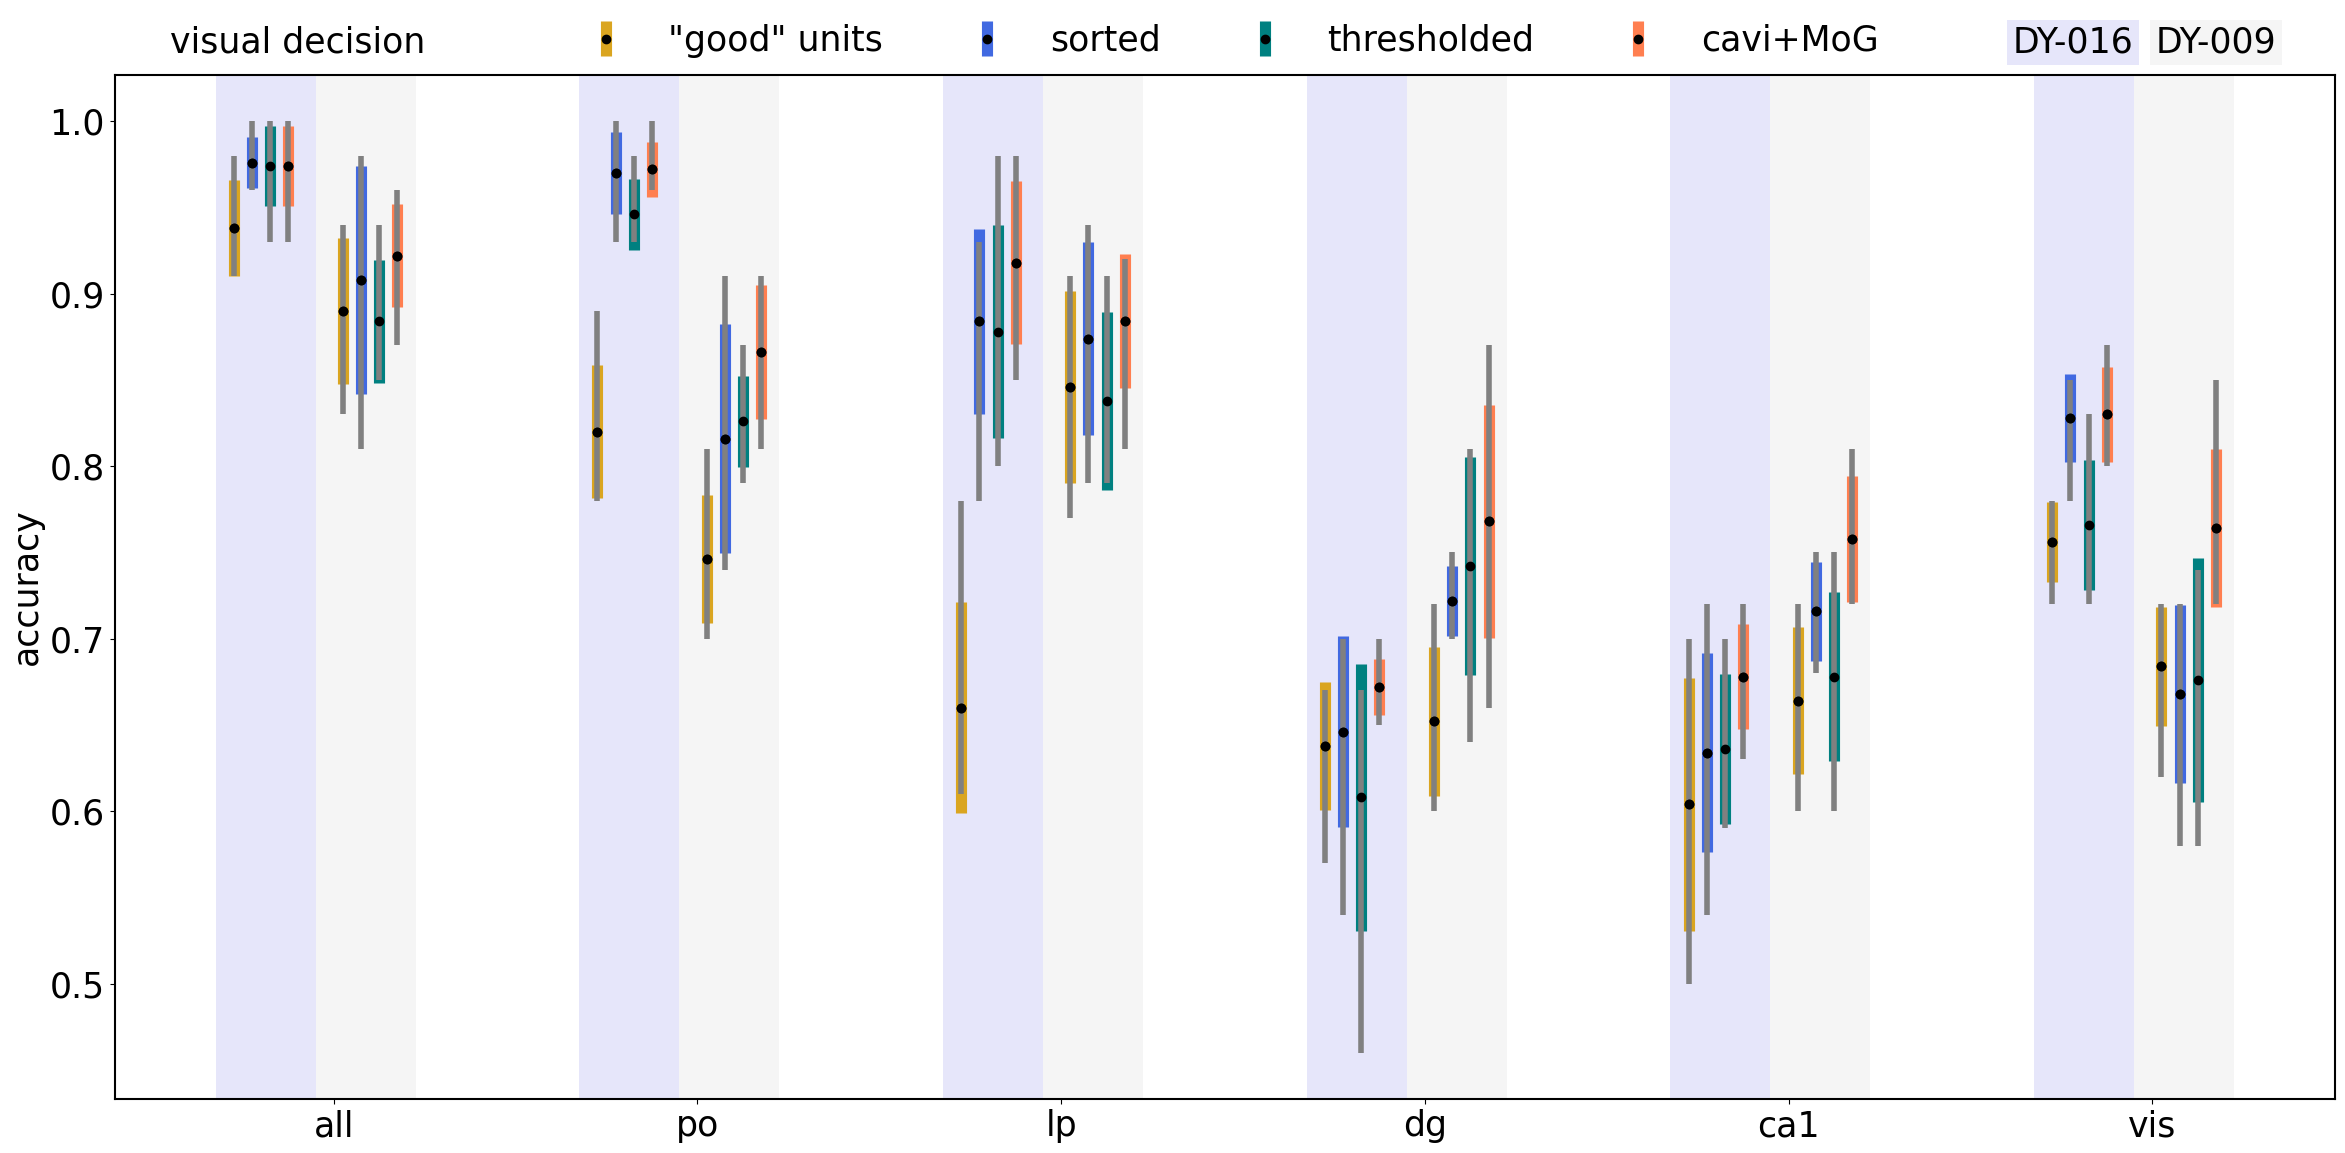

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(24, 12))

ticks = ['all', 'po', 'lp', 'dg', 'ca1', 'vis']

mins, maxs, means, stds = dy16_good_units.min(1), dy16_good_units.max(1), dy16_good_units.mean(1), dy16_good_units.std(1)
ax.errorbar(np.arange(len(ticks))*2-.2, means, stds, 
                 fmt='ok', ecolor='goldenrod', lw=8, label='"good" units')
ax.errorbar(np.arange(len(ticks))*2-.2, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_good_units.min(1), dy09_good_units.max(1), dy09_good_units.mean(1), dy09_good_units.std(1)
ax.errorbar(np.arange(len(ticks))*2-.8, means, stds, 
                 fmt='ok', ecolor='goldenrod', lw=8)
ax.errorbar(np.arange(len(ticks))*2-.8, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_sorted.min(1), dy16_sorted.max(1), dy16_sorted.mean(1), dy16_sorted.std(1)
ax.errorbar(np.arange(len(ticks))*2-.1, means, stds, 
                 fmt='ok', ecolor='royalblue', lw=8, label='sorted')
ax.errorbar(np.arange(len(ticks))*2-.1, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_sorted.min(1), dy09_sorted.max(1), dy09_sorted.mean(1), dy09_sorted.std(1)
ax.errorbar(np.arange(len(ticks))*2-.7, means, stds, 
                 fmt='ok', ecolor='royalblue', lw=8)
ax.errorbar(np.arange(len(ticks))*2-.7, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_thresholded.min(1), dy16_thresholded.max(1), dy16_thresholded.mean(1), dy16_thresholded.std(1)
ax.errorbar(np.arange(len(ticks))*2, means, stds, 
             fmt='ok', ecolor='teal', lw=8, label='thresholded')
ax.errorbar(np.arange(len(ticks))*2, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_thresholded.min(1), dy09_thresholded.max(1), dy09_thresholded.mean(1), dy09_thresholded.std(1)
ax.errorbar(np.arange(len(ticks))*2-.6, means, stds, 
             fmt='ok', ecolor='teal', lw=8)
ax.errorbar(np.arange(len(ticks))*2-.6, means, [means - mins, maxs - means],
                 fmt='.k', ecolor='gray', lw=4)

mins, maxs, means, stds = dy16_clusterless.min(1), dy16_clusterless.max(1), dy16_clusterless.mean(1), dy16_clusterless.std(1)
ax.errorbar(np.arange(len(ticks))*2+.1, means, stds, 
             fmt='ok', ecolor='coral', lw=8, label='cavi+MoG')
ax.errorbar(np.arange(len(ticks))*2+.1, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

mins, maxs, means, stds = dy09_clusterless.min(1), dy09_clusterless.max(1), dy09_clusterless.mean(1), dy09_clusterless.std(1)
ax.errorbar(np.arange(len(ticks))*2-.5, means, stds, 
             fmt='ok', ecolor='coral', lw=8)
ax.errorbar(np.arange(len(ticks))*2-.5, means, [means - mins, maxs - means],
                 fmt='ok', ecolor='gray', lw=4)

ax.legend(loc='lower left')
ax.set_xticks([-.25, 1.75, 3.75, 5.75, 7.75, 9.75], ticks)
ax.set_ylabel('accuracy')
ax.text(-1.15, 1.04, 'visual decision')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
          ncol=4, fancybox=False, shadow=False, frameon=False)

ax.axvspan(-.9, -.35, facecolor='lavender')
ax.axvspan(-.35, .2, facecolor='whitesmoke')
ax.axvspan(1.1, 1.65, facecolor='lavender')
ax.axvspan(1.65, 2.2, facecolor='whitesmoke')
ax.axvspan(3.1, 3.65, facecolor='lavender')
ax.axvspan(3.65, 4.2, facecolor='whitesmoke')
ax.axvspan(5.1, 5.65, facecolor='lavender')
ax.axvspan(5.65, 6.2, facecolor='whitesmoke')
ax.axvspan(7.1, 7.65, facecolor='lavender')
ax.axvspan(7.65, 8.2, facecolor='whitesmoke')
ax.axvspan(9.1, 9.65, facecolor='lavender')
ax.axvspan(9.65, 10.2, facecolor='whitesmoke')

ax.text(8.98, 1.04, 'DY-016', bbox={'facecolor': 'lavender', 'edgecolor':'none', 'pad':4})
ax.text(9.77, 1.04, 'DY-009', bbox={'facecolor': 'whitesmoke', 'edgecolor':'none', 'pad':4})

plt.tight_layout()
# plt.savefig('compare_decoders.png', dpi=400)